# Прогнозирование оттока клиентов банка

 На основании исторических данных о поведении клиентов и расторжении договоров с банком необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.   

 <b> Цель проекта:</b> построить модель-классификатор, которая определит вероятность того, что отдельно взятый клиент расторгнет договор с банком.

В качестве метрики качества модели мы будем использовать главным образом F1-меру, которая представляет собой баланс метрик precision и recall, а также будем оценивать AUROC моделей. Минимальным значением F1 для нас по условию является 0.59.



Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)


## План проекта:  
1. Откроем и изучим файл с данными
2. Подготовим данные к построению моделей
3. Исследуем баланс классов, обучим модели без учёта дисбаланса
4. Улучшим качество моделей, учитывая дисбаланс классов
5. Проведём финальное тестирование с лучшей моделью
6. Сделаем выводы

# 1. Изучение данных

In [1]:
import sys; print(sys.version)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import FeatureImportances

from IPython.display import display
import warnings
warnings.simplefilter("ignore")

3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:33:48) 
[GCC 7.3.0]


In [2]:
clients = pd.read_csv('/path/Churn.csv')
display(clients)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [3]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


* Данные имеют подходящие типы во всех столбцах.
* Строковые данные мы позже закодируем в числовой вид.
* Есть пропуски в столбце с данными о наличии недвижимости. Первая мысль: у этих клиентов может не быть недвижимости в собственности. Исследуем это явление позже.

In [4]:
clients.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
#Проверим данные на наличие дубликатов
clients.duplicated().sum()

0

In [6]:
#Проверим столбец ID клиента на наличие дубликатов, он важен для нас, так как прогноз будет составлять по каждому клиенту
clients['CustomerId'].duplicated().sum()

0

### Вывод
На данном этапе мы сделали первый взгляд на данные. Для дальнейшего анализа и построения модели уберем столбцы, которые никак не влияют на отток клинетов и построения модели, такие как номер строки, ID клиента и его имя (CustomerId, Surname, RowNumber). Имеются пропуски в столбце "Количество недвижимости", удалим этот столбец, так в случаt удаления пустых строк и удаления всего столбца, результат f1 различался на 0,03 и был лучше во втором случае.

In [7]:
#подготовка таблицы для дальнейшей работы
clients = clients.loc[:, ['CreditScore', 'Geography', 'Gender',
     'Age', 'Tenure', 'Balance', 'NumOfProducts', 
     'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']]
display(clients)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


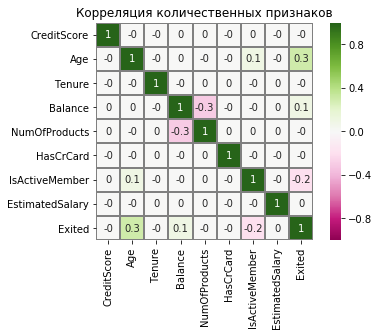

In [8]:
#проверим нет ли мультиколлинеарности между параметрами
sns.heatmap(
    round(clients.corr(), 1),
    annot = True, fmt = '.0g', square = True,
    vmin=-1, vmax=1,
    center= 0,
    linewidths=1,
    linecolor='grey',
    #mask=matrix,
    cmap= 'PiYG'
)
sns.set(rc={'figure.figsize':(7.0,7.0)})
plt.title('Корреляция количественных признаков')
plt.show()

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

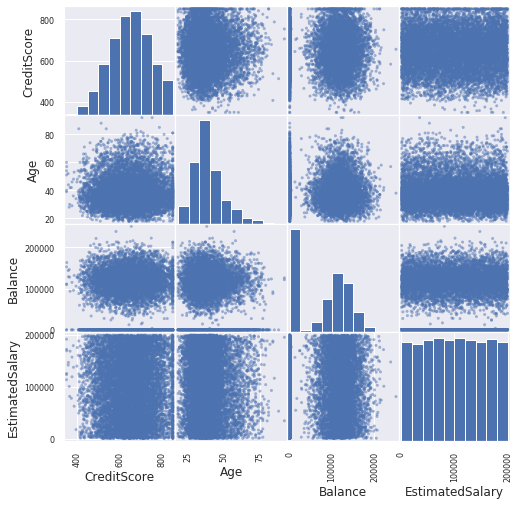

In [9]:
#посмотрим на характер зависимостей признаков 
display(clients.columns)
pd.plotting.scatter_matrix(
    clients.loc[
        :, ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']],
    figsize = (8, 8))
plt.show()

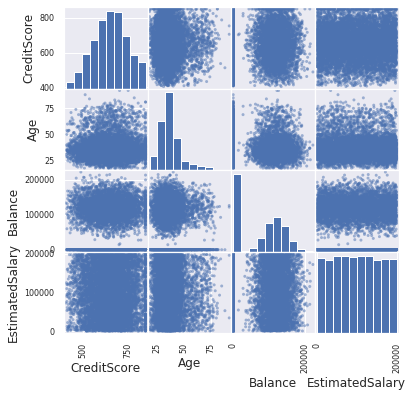

In [10]:
#посмотрим на корреляции для класса "0"
exited_0 = clients[clients['Exited'] == 0]
pd.plotting.scatter_matrix(
    exited_0.loc[
        :, ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']],
    figsize = (6, 6))
plt.show()

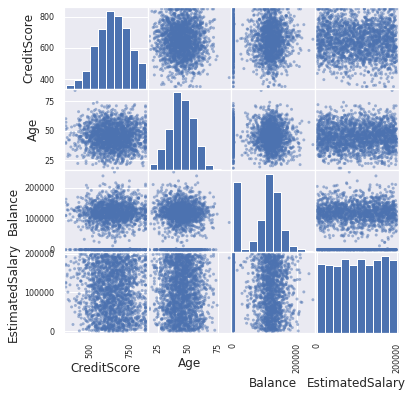

In [11]:
#посмотрим на корреляции для класса "1"
exited_0 = clients[clients['Exited'] == 1]
pd.plotting.scatter_matrix(
    exited_0.loc[
        :, ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']],
    figsize = (6, 6))
plt.show()

### Вывод
Мультиколлинерованости между параметрами нет, другие столбцы из анализа убирать не будем. Коррелиции между параметрами также не наблюдается

* Количественные признаки имеют разный масштаб: посмотрим глазами на их распределения.
 Для этого нарисуем гистограммы для каждого количественного столбца.

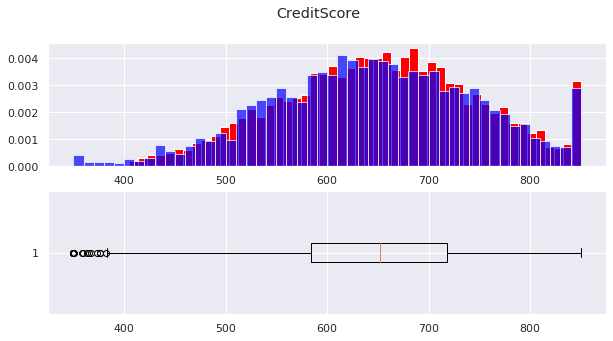

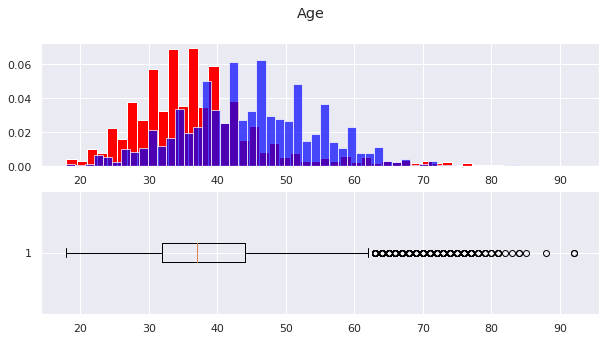

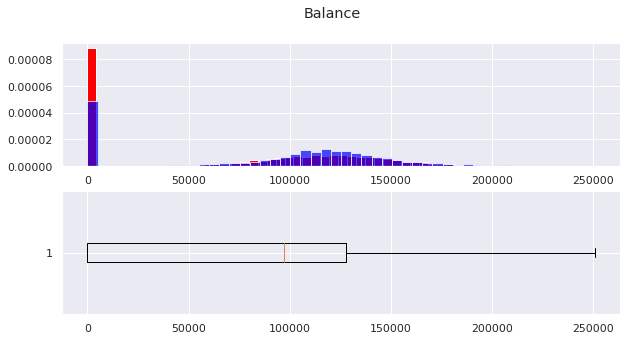

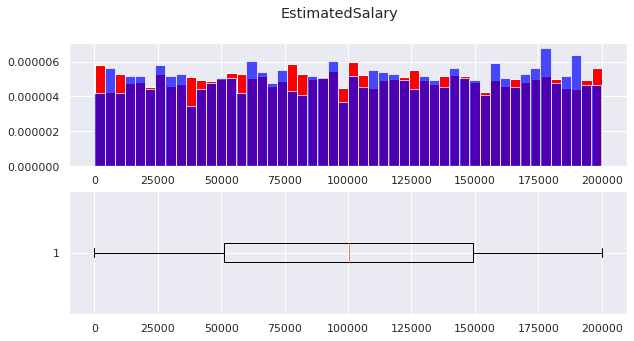

In [13]:
#строим гистограммы и боксплоты для каждого количественного признака
columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
for row in columns:
    fig, axes = plt.subplots(2, 1, figsize=(10, 5))
    axes[0].hist(clients.query('Exited == 0')[row], color = 'red', density=True, bins=50, label = 'Класс 0')
    axes[0].hist(clients.query('Exited == 1')[row], color = 'blue', density=True, bins=50, label = 'Класс 1', alpha = 0.7)
    axes[1].boxplot(clients[row], showfliers=True, vert=False)
    plt.suptitle(row)
    plt.show()

#### Вывод
По гистограмме выявлены некоторые аномалии, например, достаточно большое количество клиентов с максимальным кредитным рейтингом. Выделяются также клиенты у которых на балансе нет денежных средств. При этом распределение клиентов по заработной плате практичеси одинаковое - возможно, что наша выборка из 10000 человек стратифицирована по зарплате..

In [14]:
#посмотрим у каких клиентов наблюдается нулевой баланс с точки зрения оттока
display(clients.query('Balance == 0')['Exited'].value_counts(normalize=True))
display(clients.query('Balance == 0'))

0    0.861764
1    0.138236
Name: Exited, dtype: float64

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.0,1,1,1,101348.88,1
3,699,France,Female,39,1.0,0.0,2,0,0,93826.63,0
6,822,France,Male,50,7.0,0.0,2,1,1,10062.80,0
11,497,Spain,Male,24,3.0,0.0,2,1,0,76390.01,0
12,476,France,Female,34,10.0,0.0,2,1,0,26260.98,0
...,...,...,...,...,...,...,...,...,...,...,...
9989,841,Spain,Male,28,4.0,0.0,2,1,1,179436.60,0
9992,726,Spain,Male,36,2.0,0.0,1,1,0,195192.40,0
9994,800,France,Female,29,2.0,0.0,2,0,0,167773.55,0
9995,771,France,Male,39,5.0,0.0,2,1,0,96270.64,0


#### Вывод
Обнаружили, что нулевой баланс преобладает у клиентов, которые не ушли из банка. Возможно, это связано с тем, что это новые клиенты

In [15]:
#посмотрим у каких клиентов наблюдается максимальный кредитный скоринг с точки зрения оттока
display(clients.query('CreditScore == 850')['Exited'].value_counts(normalize=True))
display(clients.query('CreditScore == 850'))

0    0.815451
1    0.184549
Name: Exited, dtype: float64

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
38,850,France,Male,36,7.0,0.00,1,1,1,40812.90,0
180,850,Spain,Female,45,NaN,122311.21,1,1,1,19482.50,0
200,850,Spain,Male,30,2.0,141040.01,1,1,1,5978.20,0
223,850,France,Male,33,10.0,0.00,1,1,0,4861.72,1
...,...,...,...,...,...,...,...,...,...,...,...
9581,850,France,Female,28,9.0,0.00,2,1,1,164864.67,0
9646,850,Spain,Male,71,10.0,69608.14,1,1,0,97893.40,1
9688,850,France,Male,68,5.0,169445.40,1,1,1,186335.07,0
9931,850,France,Female,34,NaN,101266.51,1,1,0,33501.98,0


#### Вывод
Количество клиентос с максимальным кредитным рейтингом составляет лишь 2% от всего числа, что является некритичным для анализа

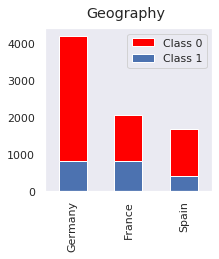

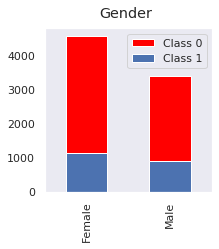

In [16]:
#строим столбчатые диаграммы для качественных признаков
columns = ['Geography', 'Gender']
for row in columns:
    clients.query('Exited == 0')[row].value_counts().plot(y=row, kind='bar', figsize=(3, 3), label = "Class 0", color='red')
    clients.query('Exited == 1')[row].value_counts().plot(y=row, kind='bar', figsize=(3, 3), label = "Class 1")
    plt.legend()
    plt.suptitle(row)
    plt.grid()
    plt.show()

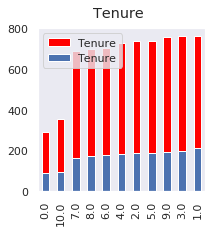

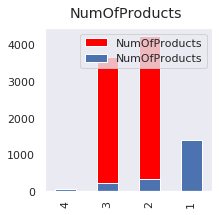

In [17]:
#строим столбчатые диаграммы для количественных признаков
columns = ['Tenure', 'NumOfProducts']
for row in columns:
    clients.query('Exited == 0')[row].value_counts(ascending=True).plot(
        y=row, kind='bar', figsize=(3, 3), legend='Class 0', color='red')
    clients.query('Exited == 1')[row].value_counts(ascending=True).plot(
        y=row, kind='bar', figsize=(3, 3), legend='Class 0')
    plt.suptitle(row)
    plt.grid()
    plt.show()

Интересный факт, что ушедшие клиенты имели в основном один продукт банка

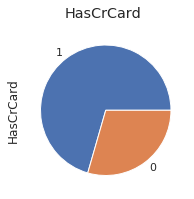

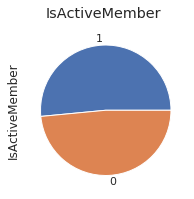

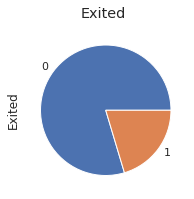

In [18]:
#строим круговые диаграммы для остальных булевых признаков
columns = ['HasCrCard', 'IsActiveMember', 'Exited']
for row in columns:
    clients[row].value_counts(normalize=True).plot(y=row, kind='pie', figsize=(3, 3))
    plt.suptitle(row)
    plt.grid()
    plt.show()

In [19]:
clients['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

## Вывод
Загрузили файл, изучили информацию. Дубликатов нет, строки с пустыми значениями отсутствуют, типы данных установлены корректно для дальнейшей работы с ними. 

Удалили столбцы, которые не повлияют на отток клинетов и лишь усложнят обучение модели (CustomerId, Surname, RowNumber).

Проверили данные на мультиколлинеарность, определили ее отсутвие.  

При анализе данных с помощью гистограм, боксплотов, столбчатых и круговых диаграмм выяснили, что представленные нам данные имеют нормальное распределение ('CreditScore', 'Age', 'Balance'), сильных выбросов нет. 

Выяснили, что существует дисбаланс классов целевого признака Exited (1 - 20%, 0 - 80%).

# 2. Подготовка данных

In [20]:
clients = clients.loc[:, ['CreditScore', 'Geography', 'Gender',
     'Age', 'Balance', 'NumOfProducts', 
     'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']]
#преобразуем категорильные признаки в численные с помощью метода OHE
clients_ohe = pd.get_dummies(clients,  drop_first=True)

#создадим таблицу с признаками и отдельно с целевым признаком
features = clients_ohe.drop(['Exited'], axis=1)
target = clients_ohe['Exited']

#разбиваем на обучающую и тестовую, тестовой отводим 20% всех данных
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)
            
#разбиваем на обучающую и валидационную, валидационной отведем 25% от обучающей выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

display(features_train.shape)
display(features_valid.shape)
display(features_test.shape)

(6000, 10)

(2000, 10)

(2000, 10)

In [21]:
#проведем стандартизацию числовых признаков на всех выборках
numeric = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 
     'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

display(features_train.shape)
display(features_valid.shape)
display(features_test.shape)

(6000, 10)

(2000, 10)

(2000, 10)

In [22]:
#смотрим как прошло разбиение данных по целевому признаку
train = target_train.value_counts()
alls = target.value_counts()
valid = target_valid.value_counts()
test = target_test.value_counts()
concat_df = pd.concat([alls, train, valid, test], axis=1)
concat_df.set_axis(['alls','train', 'valid','test'], axis = 'columns',inplace = True)
concat_df['train_per'] = round(concat_df['train']/concat_df['alls'], 3)
concat_df['valid_per'] = round(concat_df['valid']/concat_df['alls'], 3)
concat_df['test_per'] = round(concat_df['test']/concat_df['alls'], 3)

display(concat_df)

,alls,train,valid,test,train_per,valid_per,test_per
0,7963,4781,1609,1573,0.600,0.202,0.198
1,2037,1219,391,427,0.598,0.192,0.210


## Вывод  

Закодировали категориальные признаки gender и geography по принципу One-Hot Encoding.
Преобразовали количественные признаки, чтобы они воспринимались моделью не буквально, а в масштабе стандартных отклонений от среднего, одинаковом для всех количественных признаков.
Разделили данные на обучающую, валидационную и тестовую выборки.
Теперь мы готовы к обучению модели и оценке её качества.Разбиение данных прошло успешно, сохранен баланс между классами

# 3.  Исследование баланса классов. Обучение модели без учёта дисбаланса. 

In [23]:
#рассчитаем accuracy моделей

#определим accurancy для дерева рещений
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_train, target_train)
valid_prediction_tree = model_tree.predict(features_valid)
accuracy_train_tree = round(accuracy_score(target_valid, valid_prediction_tree), 2)
print('accuracy_tree =', accuracy_train_tree)

#определим accurancy для случайного леса
model_forest = RandomForestClassifier(random_state=12345)
model_forest.fit(features_train, target_train)
valid_prediction_forest = model_forest.predict(features_valid)
accuracy_valid_forest = round(accuracy_score(target_valid, valid_prediction_forest), 2)
print('accuracy_forest =', accuracy_valid_forest)

#определим  accurancy для логистической регресси
model_logistic = LogisticRegression(random_state=12345)
model_logistic.fit(features_train, target_train)
valid_prediction_logistic = model_logistic.predict(features_valid)
accuracy_valid_logistic = round(accuracy_score(target_valid, valid_prediction_logistic), 2)
print('Accuracy логистической регресси:', accuracy_valid_logistic)

accuracy_tree = 0.79
accuracy_forest = 0.85
Accuracy логистической регресси: 0.82


In [24]:
#оценим качество моделей
#посчитаем accuracy для константной модели
target_pred_constant = pd.Series(0, target_valid.index)
print('Accuracy константной модели:', accuracy_score(target_valid, target_pred_constant))

Accuracy константной модели: 0.8045


Accuracy обученных моделей и константной практически одинаковы, что говорит о низком качестве наших моделей.

In [25]:
#рассчитаем матрицу ошибок
print("Матрица ошибок дерева решений:")
print(confusion_matrix(target_valid, valid_prediction_tree))
print("Матрица ошибок случайного леса:")
print(confusion_matrix(target_valid, valid_prediction_forest))
print("Матрица ошибок логистической регрессии:")
print(confusion_matrix(target_valid, valid_prediction_logistic))

Матрица ошибок дерева решений:
[[1385  224]
 [ 202  189]]
Матрица ошибок случайного леса:
[[1533   76]
 [ 231  160]]
Матрица ошибок логистической регрессии:
[[1550   59]
 [ 310   81]]


По матрице ошибок видно, что модель довольно часто видит прогнозирует отрицательный класс, там где его нет. Например в алгоритме дерева решений ложноположительных предсказаний получилось 224, что составляет 8% от целевых признаков первого класса. Т.е. на самом деле клиент пакинул банк, а модель прогнозирует, что он останется.

### Применим другие метрики оценки качества прогноза целевого признака.

In [26]:
#полнота (recall)

print("Полнота дерева решений:", round(recall_score(target_valid, valid_prediction_tree), 2))
print("Полнота случайного леса:", round(recall_score(target_valid, valid_prediction_forest), 2))
print("Полнота логистической регрессии:", round(recall_score(target_valid, valid_prediction_logistic), 2))

Полнота дерева решений: 0.48
Полнота случайного леса: 0.41
Полнота логистической регрессии: 0.21


У дерева решений полнота выше относительно результатов других алгоритмов, однако модель недостатчно хорошо ищет положительные ответы

In [27]:
#точность (precision)

print("точность дерева решений:", round(precision_score(target_valid, valid_prediction_tree), 2))
print("точность случайного леса:", round(precision_score(target_valid, valid_prediction_forest), 2))
print("точность логистической регрессии:", round(precision_score(target_valid, valid_prediction_logistic), 2))

точность дерева решений: 0.46
точность случайного леса: 0.68
точность логистической регрессии: 0.58


Точность определения класса выше у случайного леса.

In [28]:
#F1-мера (F1-score)

print("F1-мера дерева решений:", round(f1_score(target_valid, valid_prediction_tree), 2))
print("F1-мера случайного леса:", round(f1_score(target_valid, valid_prediction_forest), 2))
print("F1-мера логистической регрессии:", round(f1_score(target_valid, valid_prediction_logistic), 2))

F1-мера дерева решений: 0.47
F1-мера случайного леса: 0.51
F1-мера логистической регрессии: 0.31


## Вывод
В общем качество модели является низким, так как accuracy на валидационной выборки и константной модели практически одинаковы (0,86 против 0,8). Поэтому были применены другие показатели качества модели. На данном этапе не очень плохо показала себя модель случайного леса, однако она проигрывает алгоритму дерево решений по показателю полноты (0,4 против 0,5). Дальше учтем дисбаланс при обучении моделей


# 4. Борьба с дисбалансом

### Проведем взвешивание классов и рассчитаем F1-score

In [29]:
#Проведем взвешивание классов и рассчитаем F1-score
#определим F1-score для дерева рещений
model_tree = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_tree.fit(features_train, target_train)
valid_prediction_tree = model_tree.predict(features_valid)
print('f1_score_tree =', round(f1_score(target_valid, valid_prediction_tree), 2))

#определим F1-score для случайного леса
model_forest = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_forest.fit(features_train, target_train)
valid_prediction_forest = model_forest.predict(features_valid)
print('f1_score_forest =', round(f1_score(target_valid, valid_prediction_forest), 2))

#определим  F1-score для логистической регресси
model_logistic = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
model_logistic.fit(features_train, target_train)
valid_prediction_logistic = model_logistic.predict(features_valid)
print('f1_score логистической регресси:', round(f1_score(target_valid, valid_prediction_logistic), 2))

f1_score_tree = 0.46
f1_score_forest = 0.53
f1_score логистической регресси: 0.48


Балансирование весов подтянуло лишь качество логистической регрессии, другим моделям же это не помогло. Проведем улучшение качества модели, учитывая дисбаланс классов. В качестве эталонной будем использовать случайный лес

### Увеличение выборки положительными ответами

In [30]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)


#определим F1-score для дерева рещений
model_tree = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_tree.fit(features_upsampled, target_upsampled)
valid_prediction_tree = model_tree.predict(features_valid)
print('f1_score_tree =', round(f1_score(target_valid, valid_prediction_tree), 2))

#определим F1-score для случайного леса
model_forest = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_forest.fit(features_upsampled, target_upsampled)
valid_prediction_forest = model_forest.predict(features_valid)
print('f1_score_forest =', round(f1_score(target_valid, valid_prediction_forest), 2))

#определим  F1-score для логистической регресси
model_logistic = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
model_logistic.fit(features_upsampled, target_upsampled)
valid_prediction_logistic = model_logistic.predict(features_valid)
print('f1_score логистической регресси:', round(f1_score(target_valid, valid_prediction_logistic), 2))

f1_score_tree = 0.46
f1_score_forest = 0.53
f1_score логистической регресси: 0.48


После увеличения выборки показатели f1-меры немного изменились для дерева решений увеличилась на 0,02, случайного леса уменьшилась на 0,02, для логистической регрессии увеличилось на 0,13.

### Уменьшение выборки отрицательными ответами

In [31]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)


#определим F1-score для дерева рещений
model_tree = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_tree.fit(features_downsampled, target_downsampled)
valid_prediction_tree = model_tree.predict(features_valid)
print('f1_score_tree =', round(f1_score(target_valid, valid_prediction_tree), 2))

#определим F1-score для случайного леса
model_forest = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_forest.fit(features_downsampled, target_downsampled)
valid_prediction_forest = model_forest.predict(features_valid)
print('f1_score_forest =', round(f1_score(target_valid, valid_prediction_forest), 2))

#определим  F1-score для логистической регресси
model_logistic = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
model_logistic.fit(features_downsampled, target_downsampled)
valid_prediction_logistic = model_logistic.predict(features_valid)
print('f1_score логистической регресси:', round(f1_score(target_valid, valid_prediction_logistic), 2))

f1_score_tree = 0.47
f1_score_forest = 0.54
f1_score логистической регресси: 0.48


После уменьшения выборки увеличился показатель f1 лишь у линйной регресси - на 0,13.

Feature ranking:
(1, 'CreditScore', 0.251)
(2, 'Age', 0.169)
(3, 'Balance', 0.164)
(4, 'NumOfProducts', 0.159)
(5, 'HasCrCard', 0.127)
(6, 'IsActiveMember', 0.043)
(7, 'EstimatedSalary', 0.031)
(8, 'Geography_Germany', 0.021)
(9, 'Geography_Spain', 0.02)
(10, 'Gender_Male', 0.014)


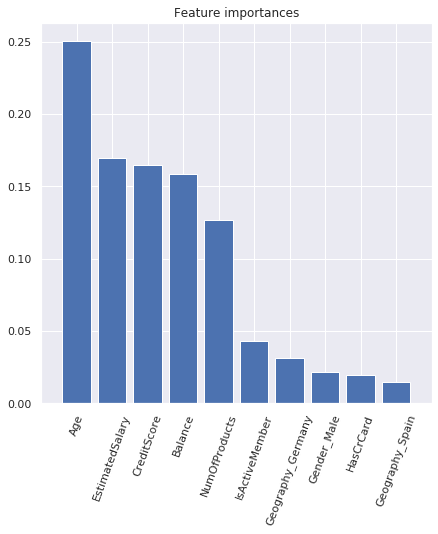

In [32]:
# Определим параметры с наибольшей значимостью
forest = RandomForestClassifier(n_estimators=250, random_state=12345)

forest.fit(features_train, target_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(features_train.shape[1]):
    print((f + 1, features_train.columns[f],  round(importances[indices[f]], 3)))

# строим график значимостей параметров
plt.figure()
plt.title("Feature importances")
plt.bar(range(features_train.shape[1]), importances[indices], align="center")
plt.xticks(range(features_train.shape[1]), features_train.columns[indices], rotation=70)
plt.xlim([-1, features_train.shape[1]])
plt.show()

Выявлено, что значимыми параметрами, вляющими на моделирование, являются Age (возраст клиента), CreditScore — кредитный рейтинг, EstimatedSalary — предполагаемая зарплата, Balance — баланс на счёте, NumOfProducts — количество продуктов банка, используемых клиентом.

### Проведем подбор гиперпараметров

In [33]:
#для испольхования наиболее значимых параметров, если необходимо будет поднять значение f1
#features_train = features_train.loc[:, ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']]

In [34]:
param_grid = {'max_depth': [deep for deep in range(2, 17)]}
gs_tree = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid)
gs_tree.fit(features_train, target_train)
print("лучшие параметры для дерева решения:", gs_tree.best_params_)

лучшие параметры для дерева решения: {'max_depth': 6}


In [35]:
param_grid = {'max_depth': [deep for deep in range(2, 17)],
             'n_estimators': [n_estimators for n_estimators in range(20, 101, 20)]}
gs_forest = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
gs_forest.fit(features_train, target_train)
print("лучшие параметры для случайного леса:", gs_forest.best_params_)

лучшие параметры для случайного леса: {'max_depth': 11, 'n_estimators': 60}


In [36]:
param_grid = {'penalty': ['l1', 'l2'],
             'C': [0.5, 0.1]}
gs_logist = GridSearchCV(LogisticRegression(), param_grid=param_grid)
gs_logist.fit(features_train, target_train)
print("лучшие параметры логистической регрессии:", gs_logist.best_params_)

лучшие параметры логистической регрессии: {'C': 0.1, 'penalty': 'l1'}


### Проведем обучение модели с подобранными оптимальными параметрами и выберем лучшую

In [37]:
#features_valid = features_valid.loc[:, ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']]

#определим F1-score для дерева рещений
model_tree = DecisionTreeClassifier(random_state=12345, class_weight='balanced', max_depth = 6)
model_tree.fit(features_train, target_train)
valid_prediction_tree = model_tree.predict(features_valid)
print('f1_score_tree =', round(f1_score(target_valid, valid_prediction_tree), 2))

#определим F1-score для случайного леса
model_forest = RandomForestClassifier(random_state=12345, class_weight='balanced', max_depth = 11, n_estimators = 60)
model_forest.fit(features_train, target_train)
valid_prediction_forest = model_forest.predict(features_valid)
print('f1_score_forest =', round(f1_score(target_valid, valid_prediction_forest), 2))

#определим  F1-score для логистической регресси
model_logistic = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear', C= 0.1, penalty= 'l1')
model_logistic.fit(features_train, target_train)
valid_prediction_logistic = model_logistic.predict(features_valid)
print('f1_score логистической регресси:', round(f1_score(target_valid, valid_prediction_logistic), 2))

f1_score_tree = 0.56
f1_score_forest = 0.59
f1_score логистической регресси: 0.48


## Вывод
В итоге наибольшую f1-мера показала модель случайного леса. Применим ее на тестовой выборке.

# 5. Тестирование модели

In [38]:
#тестируем модель на тестовой выборке, обучаем на обобщенной выборке(трайн+валид)

#features_test = features_test.loc[:, ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']] #для использования наиболее значимых параметров

features_train_valid = pd.concat([features_train, features_valid])
target_train_valid = pd.concat([target_train, target_valid])

model_train_valid = RandomForestClassifier(random_state=12345, class_weight='balanced', max_depth = 11, n_estimators = 60)
model_train_valid.fit(features_train_valid, target_train_valid)

prediction_test = model_train_valid.predict(features_test)
print('f1_score_test =', round(f1_score(target_test, prediction_test), 2))

f1_score_train_valid = 0.63


In [39]:
print("Полнота случайного леса тестовой выборки:", round(recall_score(target_test, prediction_test), 2))
print("Точность случайного леса тестовой выборки:", round(precision_score(target_test, prediction_test), 2))

#Полнота случайного леса: 0.72 - в случае предсказания на пяти значимых признаках
#точность случайного леса: 0.52 - в случае предсказания на пяти значимых признаках

Полнота случайного леса: 0.63
точность случайного леса: 0.64


In [47]:
print("Качество предсказаний случайного леса тестовой выборки:")
print()
print(classification_report(target_test, prediction_test))

Качество предсказаний случайного леса тестовой выборки:

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1573
           1       0.64      0.63      0.63       427

    accuracy                           0.84      2000
   macro avg       0.77      0.76      0.77      2000
weighted avg       0.84      0.84      0.84      2000



In [46]:
print("Матрица ошибок случайного леса тестовой выборки:")
print(confusion_matrix(target_test, prediction_test))

Матрица ошибок случайного леса тестовой выборки:
[[1422  151]
 [ 160  267]]


## Вывод
Выбранная нами модель RandomForestClassifier с глубиной 11, количеством наблюдателей на тестовой выборке составила 0,63, что является довольно высоких показателем и свидетельствует об оптимальности выбранной модели. Так же на тестовой выборке улучшилась полнота предсказания первого класса (увеличилась с 0,4 до 0,6), что свидетельствует об оптимальности модели и целесообразности ее использования.

Так же бизнесу будет интересно знать, что существует пять важных параметров, которые в большей степени влияют на уход клиента

### Проведем изменение порога для логистической регрессии, так как возможно это даст лучший результат F1-метрики

In [41]:
#поменяем вероятности появления классов с помощью predict_proba()
model_logistic = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
model_logistic.fit(features_train, target_train)
probabilities_valid_logistic = model_logistic.predict_proba(features_test) #вычисляем вероятности появления классов
probabilities_one_valid_logistic = probabilities_valid_logistic[:, 1] #Значения вероятностей класса «1»

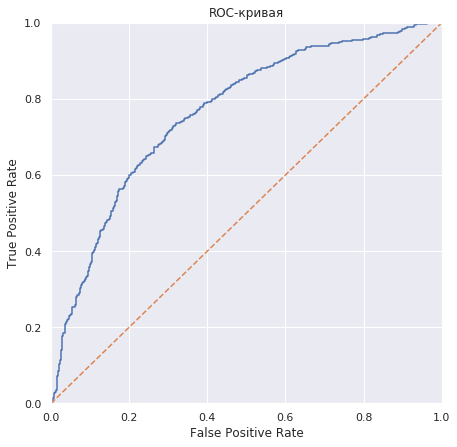

In [42]:
#построим ROC-кривую
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid_logistic)
plt.figure()
plt.plot(fpr, tpr, linestyle='-')
#график для случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [45]:
#площадь под ROC-кривой
auc_roc = roc_auc_score(target_test, probabilities_one_logistic)
print('Площадь ROC-кривой для тестовой выборки:', round(auc_roc, 2))
display(clients)

Площадь ROC-кривой для тестовой выборки: 0.77


,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,75075.31,2,1,0,92888.52,1


# 6. Общий вывод  

Нашей задачей было построить модель, которая предсказывала бы вероятный уход клиентов из банка, чтобы суметь их вовремя выявить и удержать.  
Мы изучили датасет и подготовили его к обучению:
* Избавились от лишних данных.
* Закодировали категориальные признаки по принципу One-Hot.
* Отмасштабировали количественные признаки, чтобы повысить точность логистической регрессии.
* Обучили модели дерева решений, случайного леса и логистической регрессии.
* Без учёта дисбалансов класса только случайный лес показал достаточный результат.
* С учётом дисбаланса качество моделей улучшилось.
* Проверили случайный лес с оптимальными параметрами на тестовой выборке и получили F1, достаточное по условию проекта.
* Auc_roc модели логистической регрессии тестовой выборки = 0,77. Что отражает выское качество нашей модели.
